In [1]:
import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt

from gprob import normal, stack, cov

# Random variables

Random variables are created using the `normal` function. For example, creating a scalar random variable can look like

In [2]:
x = normal(0, 1)
x

Normal(mean=0, var=1)

Variables have mean, variance, and covaraince (the same as variance in the scalar case), and can be sampled

In [3]:
print(x.mean())
print(x.var())
print(x.sample())

0
1.0
1.764052345967664


One can, conversely, also find the log likelyhood of a sample

In [4]:
x.logp(0.1)

-0.9239385332046727

One way to create higher-dimensional variables is by specifying their mean and covariance

In [5]:
x = normal(mu=[-1, 2], sigmasq=[[1, 0.5], [0.5, 1]])
x.cov()

array([[1. , 0.5],
       [0.5, 1. ]])

More interestingly, however, multivariate distributions can be constructed using arithmetic and other operations. For example,

In [6]:
v1 = normal()  # a scalar
v2 = normal()
v3 = normal()
v4 = normal()

v1 = v1 + 0.93
v5 = v3 - 2 * v4

vm1 = stack([v1, v2])  # a 1D vector
vm2 = stack([v2, v4])

Now `v5` is correlated with `vm2`, because they both depend on `v4`

In [7]:
cov(vm2, v5)

array([ 0., -2.])

# Conditional inference

The joint distribution for `v1` and `v2` is a product distribution, as can be seen by sampling

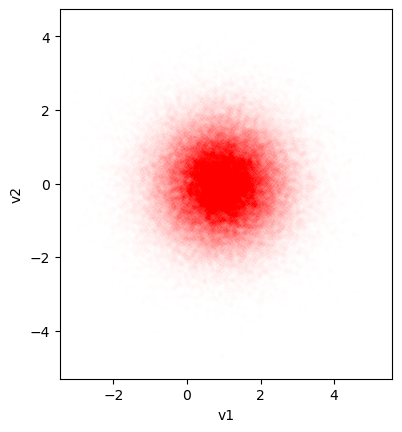

In [8]:
samples = vm1.sample(10**5)
plt.plot(samples[:, 0], samples[:, 1], 'r.', alpha=0.005)
plt.xlabel('v1')
plt.ylabel('v2')
plt.gca().set_aspect('equal')

Variables can be conditioned on a set of observations using `|` operation, or their `condition` method. For example, the joint distribution of `v1` and `v2` under the condition that their sum is 1 is constructed as follows

In [9]:
vc = stack([v1, v2]) | {v1 + v2: 1}

By sampling from the conditional distribution, we can indeed verify that `v1+v2==1`

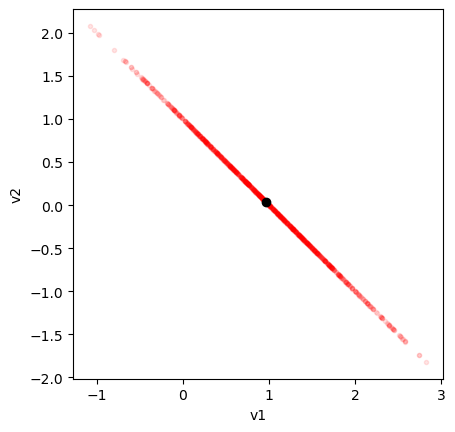

In [10]:
samples = vc.sample(10**3)
plt.plot(samples[:, 0], samples[:, 1], 'r.', alpha=0.1)
plt.xlabel('v1')
plt.ylabel('v2')
plt.plot(*vc.mean(), 'ko')
plt.gca().set_aspect('equal')

The conditional mean and covariance also show the same

In [11]:
vc.mean(), vc.cov()

(array([0.965, 0.035]),
 array([[ 0.5, -0.5],
        [-0.5,  0.5]]))

The original variables remain unaffected - conditioning has no side effects

In [12]:
cov(v1, v2)

array(0.)

Conditioning can be "hard", as in the previous example, meaning that the conditions take numerical values, or "soft", meaning that the conditions take random values. To give an example of soft conditioning, we can add some uncertainty to the observation `v1+v2==1` 

In [13]:
vc = stack([v1, v2]) | {v1 + v2: normal(1, 0.1)}

The new joint conditional distribution of `v1` and `v2` is

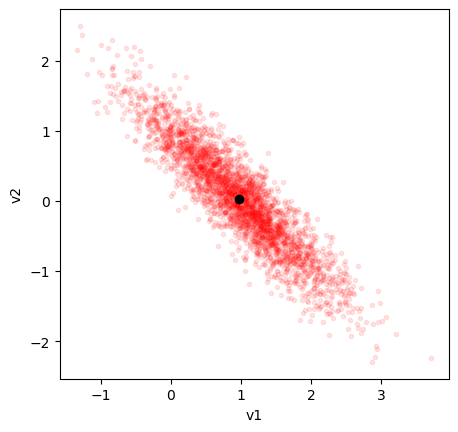

In [14]:
samples = vc.sample(3 * 10**3)
plt.plot(samples[:, 0], samples[:, 1], 'r.', alpha=0.1)
plt.xlabel('v1')
plt.ylabel('v2')
plt.plot(*vc.mean(), 'ko')
plt.gca().set_aspect('equal')

# Ornstein–Uhlenbeck process

As the next example, we can construct a discrete approximation of an Ornstein–Uhlenbeck process,

$$ dx=-x(t) dt + dW, $$

with unit time constant and stationary variance. 

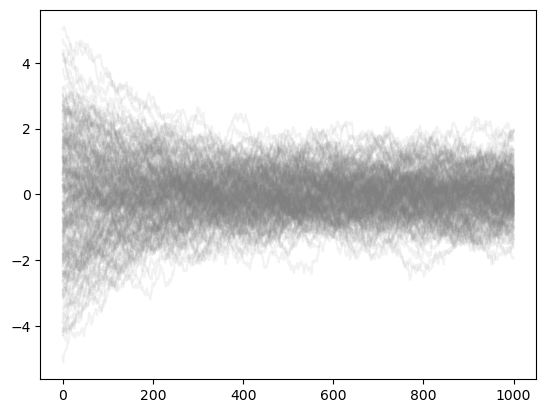

In [15]:
nstep = 10**3
dt = 5 / nstep
nsample = 2 * 10**2

x = [None] * (nstep + 1)

x[0] = normal(0, 4)  # The initial condition.
for i in range(nstep):
    x[i+1] = x[i] - x[i] * dt + normal(0, dt)

xs = stack(x)
samples = xs.sample(nsample)

plt.plot(samples.T, alpha=0.1, color='gray');

Conditioning the process on several observations throughout the evolution time:

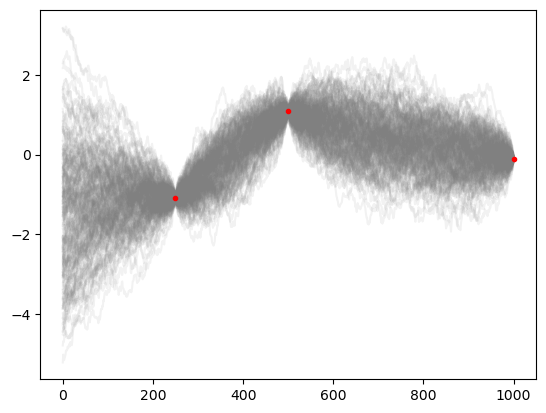

In [16]:
steps = [nstep//4, nstep//2, len(x)-1]
obs = [-1.1, 1.1, -0.1]

xs = stack(x) | {x[i]: v for i, v in zip(steps, obs)}
samples = xs.sample(nsample)

plt.plot(samples.T, alpha=0.1, color='gray')
plt.plot(steps, obs, color='r', marker='.', ls='none');